# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Global Horizontal Irradiance (GHI) assessment and forecast

Author: N. Chéa

### Project objectives
<div class="alert alert-block alert-info">

- Assess the relationship between satellite-observed cloud albedo, meteorological variables and Global Horizontal Irradiance (GHI). 
- Forecast GHI using the past observations of satellite-observed cloud albedo and meteorological variables
</div>

### Dataset

**SIRTA Observatory**

The SIRTA atmospheric research observatory is one of the few sites in Europe offering the instrumentation and facilities needed to study atmospheric physico-chemical processes from the surface through the boundary layer to the upper troposphere. It is located on the Polytechnique Campus and routinely measures the air temperature (°C), wind speed (m/s), wind direction (°) along with many other variables.

**Global Horizontal Irradiance**

Global Horizontal Irradiance (GHI) is the total amount of shortwave solar radiation received from the sun by a horizontal surface on the ground. This measure, expressed in watts per square meter (W/m²), includes Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI), capturing the full spectrum of solar energy contributions during daylight hours.  
The GHI is measured using a pyranometer installed at SIRTA (https://en.wikipedia.org/wiki/Pyranometer) capturing the full solar spectrum (0.3 to 2.8 $\mu\text{m}$). 

**Cloud albedo**

Cloud albedo (from 0 to 1, unitless) refers to an estimation of the fraction of solar radiation that is reflected by the cloud cover back into space, significantly influencing the Earth's energy balance.  
In this section, we will use the High Resolution Visible (HRV) channel (wavelengths between 0.3 to 1.1 $\mu\text{m}$) of SEVIRI instrument from MSG-4 satellite to compute the cloud albedo at a spatial resolution of 1x1 km$^2$. (https://www.eumetsat.int/meteosat-second-generation) We have extracted 5 tiles for which the albedo is computed: a tile centered on the SIRTA's location and the four neighboring tiles. 

### First steps

- Read about solar energy assessment and forecast 
- Identify key variables of interest linked to GHI
- Estimate GHI using the relevant variables

### Data loading and pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

dir0 = Path('../../../data/projects/sirta_ghi')
file_albedo_sirta = 'cloud_albedo_data_sirta.csv'
file_ghi_sirta = 'ghi_sirta.csv'
file_external_sirta = 'external_sirta_data.csv'


df_cloud_albedo = pd.read_csv(Path(dir0, file_albedo_sirta), index_col="Unnamed: 0")
df_cloud_albedo.index.names = ['date']

df_ghi = pd.read_csv(Path(dir0, file_ghi_sirta), index_col="date")      
df_ghi = df_ghi.loc[~df_ghi.index.duplicated(keep='first')]

df_external_sirta = pd.read_csv(Path(dir0, file_external_sirta), index_col="date")
df_cloud_albedo.index = pd.to_datetime(df_cloud_albedo.index)
df_ghi.index = pd.to_datetime(df_ghi.index)
df_external_sirta.index = pd.to_datetime(df_external_sirta.index)
df_cloud_albedo_shifted = df_cloud_albedo.shift(11, freq='min')

df = pd.concat([df_cloud_albedo_shifted, df_ghi, df_external_sirta], axis=1, join='inner')
df = df.drop(["Sat_GHI", "Clearsky_GHI", "Arpege_GHI"], axis=1)
df.replace('--', np.nan, inplace=True)
df = df.dropna()
df = df.astype(float)

df['Cloud_Albedo_center'] = df['Cloud_Albedo_center'].clip(lower=0, upper=1)
df['Cloud_Albedo_up'] = df['Cloud_Albedo_up'].clip(lower=0, upper=1)
df['Cloud_Albedo_right'] = df['Cloud_Albedo_right'].clip(lower=0, upper=1)
df['Cloud_Albedo_left'] = df['Cloud_Albedo_left'].clip(lower=0, upper=1)
df['Cloud_Albedo_down'] = df['Cloud_Albedo_down'].clip(lower=0, upper=1)
df['Sirta_GHI'] = df['Sirta_GHI'].clip(lower=0)

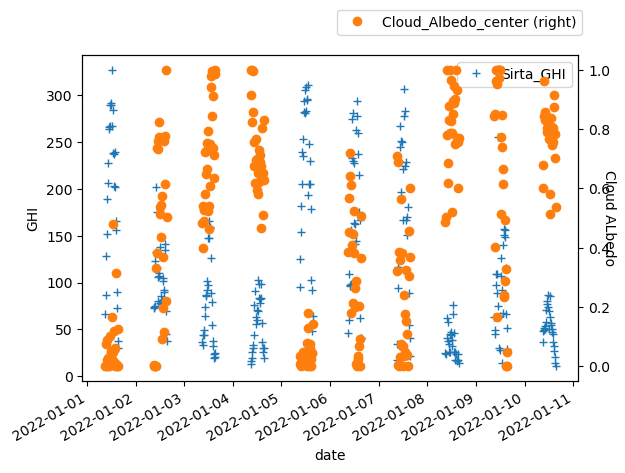

In [2]:
ax = df['Sirta_GHI'].loc['2022-01-01':'2022-01-10'].plot(ylabel='GHI', style='+', legend=True)
plt.legend(loc='center left', bbox_to_anchor=(0.1, 1.1))
df['Cloud_Albedo_center'].loc['2022-01':'2022-01-10'].plot(ax=ax,secondary_y=True, style='o')
plt.ylabel('Cloud ALbedo', fontsize=10, rotation=-90)
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.1))

- Do you notice a pattern between the GHI and cloud albedo?
- How could you use the cloud albedo to predict the GHI?
- What are the implications for GHI prediction?

### Dataset

- Observed monthly VRE capacity factors averaged over metropolitan France regions from 2014 to 2021
- Climate variables of your choice from a global reanalysis with an hourly sampling from 2010 to 2019

### First steps

- Choose from solar or wind power
- Read about solar/wind production assessment and forecast
- Estimate the hourly solar/wind production

### Reading the data

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Directories where you saved the data
data_dir_energy = Path('../../../data/projects/energy_france')
data_dir_climate = Path('../../../data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

# Read a climate variable and plot its mean over time
variable_name = 'zonal_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_climate = xr.load_dataset(filepath)[variable_name]
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate.mean('time'))

# Compute regional mean of climate variable and plot time series
da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure()
da_climate_reg.plot.line(x='time')

# Read energy variable and plot time series
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot()

FileNotFoundError: [Errno 2] No such file or directory: '/home/bderembl/teaching/mec557/data/projects/climate_france/mask_datagouv_french_regions_merra2_Nx_France.nc'

<img alt="weather" src="images/ENSO-normal.png" width=400 style="float:left">
<img alt="weather" src="images/ENSO-El_Nino.png" width=400 style="float:right">

- Natural mode of variability of the pacific equatorial ocean
- Big impact on the local economy
- Question: What is the predictability of El Nino?

### Data set

<img alt="weather" src="images/monthly-sst-lanina-normal-elnino.png" width=400>

- Variable: Global sea surface temperature (SST)
- Temporal resolution: monthly mean
- Spatial resolution: 1 degree$\times$1 degree

### First steps

- Read about El nino
- Characterize El nino: i.e. introduce a classifier
- What does it mean ``to make a prediction''?

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr

dir0 = Path('../../../data/projects/el_nino/')
file_sst = 'sst.mnmean.nc'

# load the data set with xarray
ds = xr.open_dataset(Path(dir0, file_sst))

# the name of the variable is 'sst'
p = ds["sst"].isel(time=0).plot.contourf(levels=20, center=False)

<img alt="weather" src="images/map.png" width=400>

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris

### Data set

<img alt="weather" src="images/annual_temperature.png" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

In [ ]:
from pathlib import Path
import pandas as pd
import xarray as xr

dir0 = Path('../../../data/projects/weather/paris/')
file_t2m = 't2m.nc'

ds = xr.open_dataset(Path(dir0, file_t2m))

# convert to pandas dataframe
df = ds.to_dataframe()

# remove latitude and longitude indices
df = df.droplevel([0,1])

df[df.index.year==2000].plot()

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>